Exploratory Data Analysis (EDA) for Emotion Detection
FC110533_FC211006_Dulith - AlexNet Architecture

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from keras.preprocessing.image import load_img


# Set visualization styles
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [ ]:
# Dataset Paths 

train_path = "/workspaces/Emotion_detector/Data/images/images/train"
val_path = "/workspaces/Emotion_detector/Data/images/images/validation"

alexnet_size = 227  # AlexNet input size (227x227)
original_size = 48  # Original image size in dataset

print(f"AlexNet input size: {alexnet_size}x{alexnet_size}")
print(f"Original image size: {original_size}x{original_size}")
print(f"Scaling factor needed: {alexnet_size/original_size:.2f}x")

AlexNet input size: 227x227
Original image size: 48x48
Scaling factor needed: 4.73x


In [50]:
# Overview of the Dataset

def count_images_per_class(path):
    counts = {}
    if os.path.exists(path):
        for class_name in os.listdir(path):
            class_path = os.path.join(path, class_name)
            if os.path.isdir(class_path):
                image_files = [f for f in os.listdir(class_path) \
                             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
                counts[class_name] = len(image_files)
    return counts

train_counts = count_images_per_class(train_path)
val_counts = count_images_per_class(val_path)

print("DATASET OVERVIEW")
print("- - - - - - - - - ")
print(f"Training classes: {len(train_counts)}")
print(f"Validation classes: {len(val_counts)}")
print(f"Total training images: {sum(train_counts.values()):,}")
print(f"Total validation images: {sum(val_counts.values()):,}")
print(f"Train/Val split: {sum(train_counts.values()):,}/{sum(val_counts.values()):,}")
print(f"Split ratio: {sum(train_counts.values())/(sum(train_counts.values()) + sum(val_counts.values())):.1%}")
print(f"Total dataset size: {sum(train_counts.values()) + sum(val_counts.values()):,}")
print(f"\nClass names: {list(train_counts.keys())}")

DATASET OVERVIEW
- - - - - - - - - 
Training classes: 7
Validation classes: 7
Total training images: 28,821
Total validation images: 7,066
Train/Val split: 28,821/7,066
Split ratio: 80.3%
Total dataset size: 35,887

Class names: ['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']


In [ ]:
# Detailed Class Distribution Analysis

print("IMAGE COUNTS PER CLASS")
print("- - - - - - - - - - - - ")
print("\nTraining Set:")
for expression in train_counts:
    print(f"{train_counts[expression]:,} {expression} images")
print("\nValidation Set:")
for expression in val_counts:
    print(f"{val_counts[expression]:,} {expression} images")


df_train = pd.DataFrame(list(train_counts.items()), columns=["Expression", "Count"])
df_train["Set"] = "Train"
df_train["Percentage"] = (df_train["Count"] / df_train["Count"].sum()) * 100
df_val = pd.DataFrame(list(val_counts.items()), columns=["Expression", "Count"])
df_val["Set"] = "Validation"
df_val["Percentage"] = (df_val["Count"] / df_val["Count"].sum()) * 100


print("\n\nPERCENTAGE DISTRIBUTION")
print("- - - - - - - - - - - - ")
print("Training Set:")
for _, row in df_train.iterrows():
    print(f"{row['Expression']}: {row['Percentage']:.1f}%")
print("\nValidation Set:")
for _, row in df_val.iterrows():
    print(f"{row['Expression']}: {row['Percentage']:.1f}%")

IMAGE COUNTS PER CLASS
- - - - - - - - - - - - 

Training Set:
7,164 happy images
4,938 sad images
4,103 fear images
3,205 surprise images
4,982 neutral images
3,993 angry images
436 disgust images

Validation Set:
1,825 happy images
1,139 sad images
1,018 fear images
797 surprise images
1,216 neutral images
960 angry images
111 disgust images


PERCENTAGE DISTRIBUTION
- - - - - - - - - - - - 
Training Set:
happy: 24.9%
sad: 17.1%
fear: 14.2%
surprise: 11.1%
neutral: 17.3%
angry: 13.9%
disgust: 1.5%

Validation Set:
happy: 25.8%
sad: 16.1%
fear: 14.4%
surprise: 11.3%
neutral: 17.2%
angry: 13.6%
disgust: 1.6%


In [51]:
# Distribution Consistency Analysis

print("DISTRIBUTION CONSISTENCY ANALYSIS")
print("- - - - - - - - - - - - - - - - - -")
consistency_issues = []
for expr in train_counts.keys():
    train_pct = (train_counts[expr] / sum(train_counts.values())) * 100
    val_pct = (val_counts[expr] / sum(val_counts.values())) * 100
    diff = abs(train_pct - val_pct)
    status = "- -Consistent" if diff < 2 else "- -Inconsistent"
    print(f"{expr}: Train {train_pct:.1f}% | Val {val_pct:.1f}% | Diff {diff:.1f}% {status}")
    if diff > 2:
        consistency_issues.append(expr)
if consistency_issues:
    print(f"\nClasses with distribution issues: {consistency_issues}")
else:
    print("\nAll classes have consistent distributions")


DISTRIBUTION CONSISTENCY ANALYSIS
- - - - - - - - - - - - - - - - - -
happy: Train 24.9% | Val 25.8% | Diff 1.0% - -Consistent
sad: Train 17.1% | Val 16.1% | Diff 1.0% - -Consistent
fear: Train 14.2% | Val 14.4% | Diff 0.2% - -Consistent
surprise: Train 11.1% | Val 11.3% | Diff 0.2% - -Consistent
neutral: Train 17.3% | Val 17.2% | Diff 0.1% - -Consistent
angry: Train 13.9% | Val 13.6% | Diff 0.3% - -Consistent
disgust: Train 1.5% | Val 1.6% | Diff 0.1% - -Consistent

All classes have consistent distributions


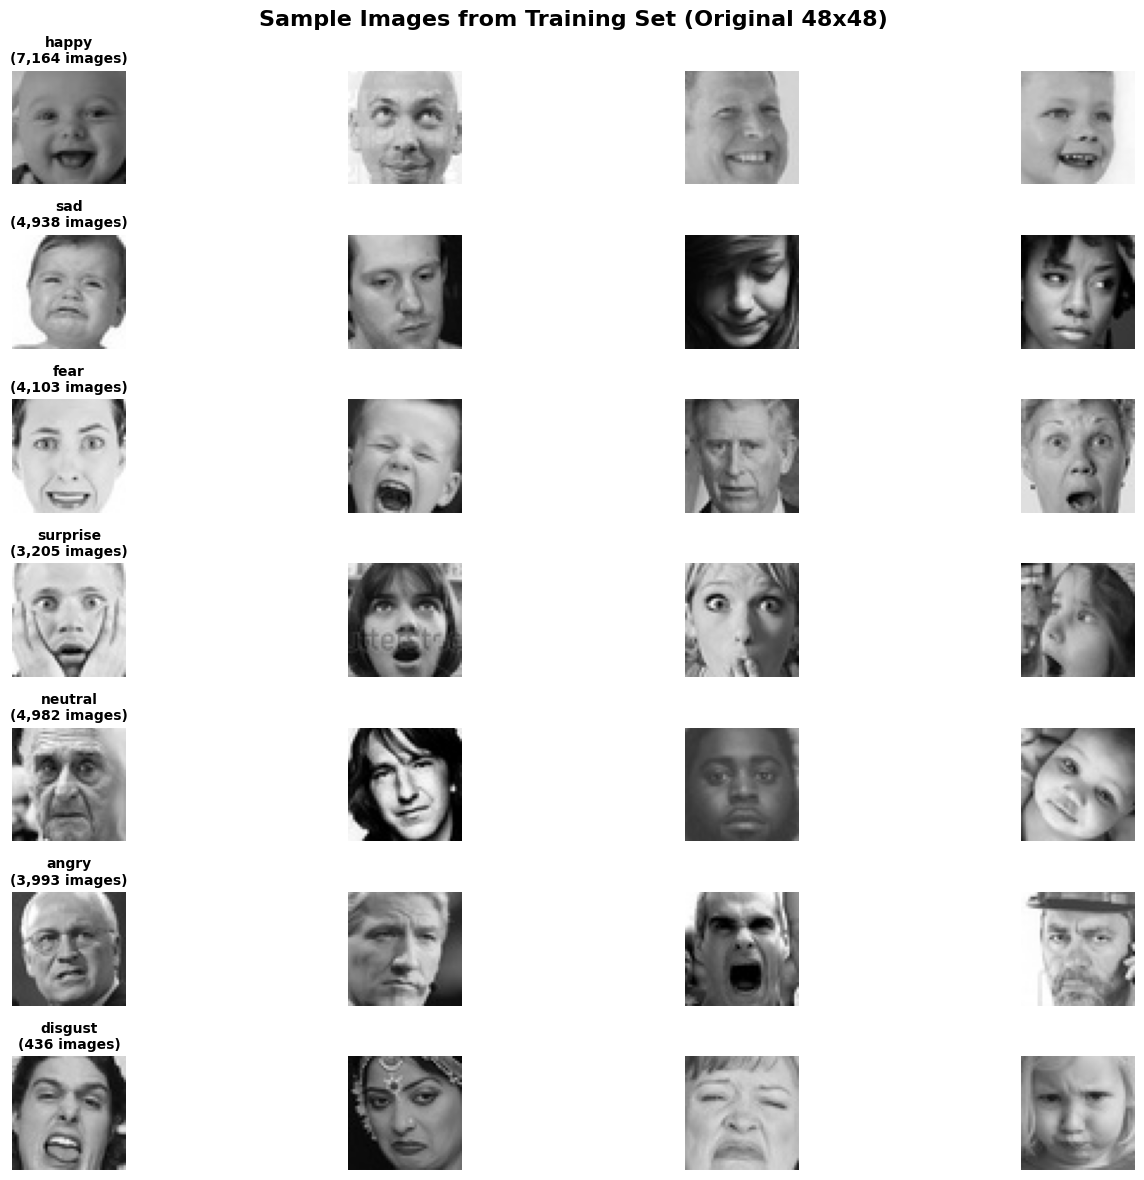

In [ ]:
# Visual Analysis - Sample Images

plt.figure(figsize=(15, 12))
cpt = 0
for expression in os.listdir(train_path):
    if os.path.isdir(os.path.join(train_path, expression)):
        expression_files = os.listdir(os.path.join(train_path, expression))
        for i in range(min(4, len(expression_files))):  # Show 4 samples per class
            cpt += 1
            plt.subplot(7, 4, cpt)
            img_path = os.path.join(train_path, expression, expression_files[i])
            try:
                img = load_img(img_path, target_size=(original_size, original_size))
                plt.imshow(img, cmap="gray")
                plt.axis('off')
                if i == 0:
                    plt.title(f"{expression}\n({train_counts[expression]:,} images)", fontsize=10, fontweight='bold')
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
plt.suptitle('Sample Images from Training Set (Original 48x48)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

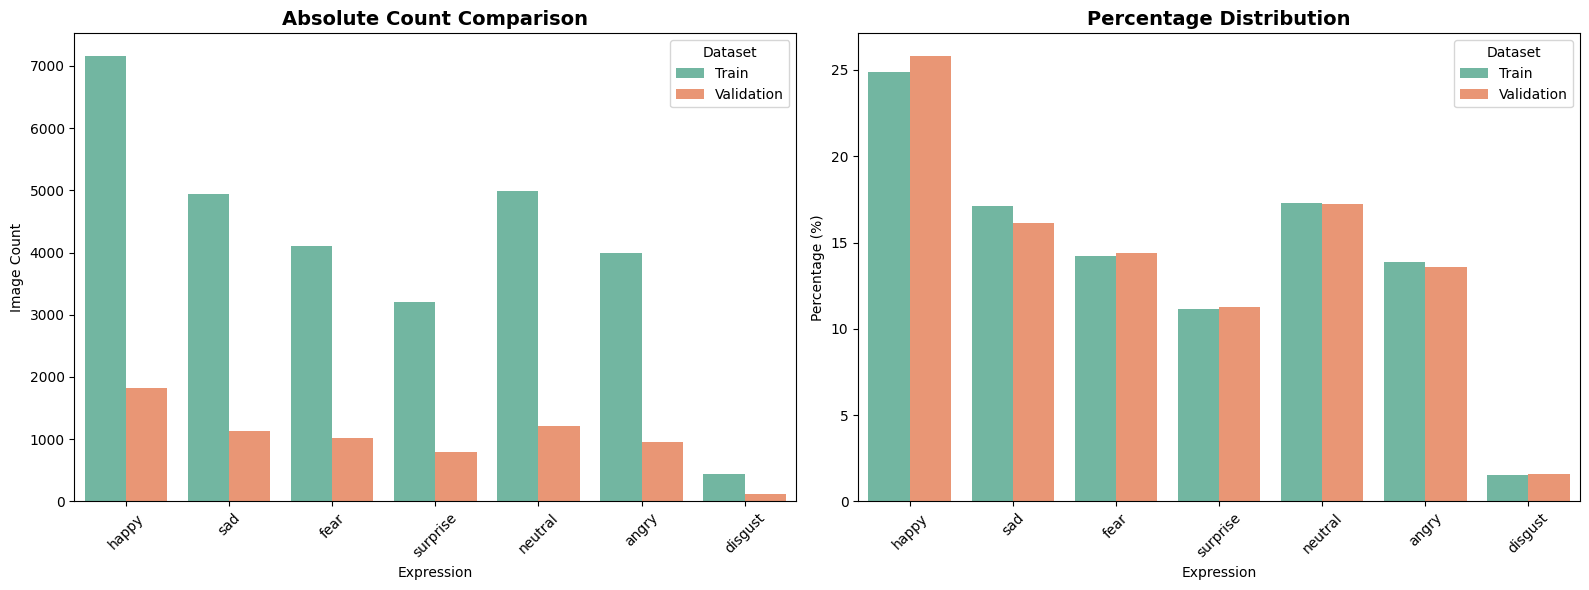

In [48]:
# Distribution Visualization (Absolute + Percentage only)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
df_combined = pd.concat([df_train, df_val], axis=0)

sns.barplot(data=df_combined, x="Expression", y="Count", hue="Set", palette="Set2", ax=axes[0])
axes[0].set_title("Absolute Count Comparison", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Expression")
axes[0].set_ylabel("Image Count")
axes[0].legend(title="Dataset")
axes[0].tick_params(axis='x', rotation=45)

df_percentage = pd.concat([
    df_train[["Expression", "Percentage", "Set"]],
    df_val[["Expression", "Percentage", "Set"]]
], axis=0)

sns.barplot(data=df_percentage, x="Expression", y="Percentage", hue="Set", palette="Set2", ax=axes[1])
axes[1].set_title("Percentage Distribution", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Expression")
axes[1].set_ylabel("Percentage (%)")
axes[1].legend(title="Dataset")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()